In [1]:
import os
import matplotlib.pyplot as plot
filepath = os.getcwd() + '/'
# non ci serve
if "HADOOP_CONF_DIR" in os.environ.keys():
    os.environ.pop("HADOOP_CONF_DIR")

/home/merlinuser/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/merlinuser/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# PySpark ML
Questo notebook contiene materiale di studio, esempi e esercizi su come usare PySpark per il machine learning. [Qui](https://spark.apache.org/docs/latest/mllib-guide.html) la documentazione ufficiale.

In [2]:
from pyspark import SparkContext, SQLContext
from pyspark.sql.functions import UserDefinedFunction as udf
from pyspark.sql.types import DoubleType

In [3]:
sc = SparkContext("local[*]", "04_Python_ML")
sqlContext = SQLContext(sc)

# Principi di base del Machine Learning

## Unsupervised Learning: Clustering

Il **Unsupervised Learning** è la tecnica di machine learning che permette di fare inferenza su dati non etichettati per descrivere eventuali strutture "nascoste".

Il fatto che i campioni sottomessi al modello non sono classificati, non esiste una valutazione dell'accuratezza a priori del modello e questo è uno dei punti di distinzione tra modelli supervisionati e non supervisionati.

## Supervised Learning: Classificazione e regressione

Nel **Supervised Learning** abbiamo un dataset in cui sono presenti sia _features_ (i dati di un campionamento) che _labels_ (le etichette con cui sono classificati i dati).
Il problema è costruire un stimatore statistico che sia in grado di predirre l'etichetta di un campione dato un insieme di features associate al campione stesso. Un esempio relativamente semplice consiste nel predirre le varietà di fiori di _iris_ data la dimensione del fiore stesso. 
Altri esempi più complicati sono:

* Data un'immagine a colori presa da un telescopio, determinare se l'oggetto raffigurato si tratta di una stella, un quasar, oppure una galassia.
* Data la foto di una persona, identificare la persona nella foto.
* Data la lista di film che un'utente ha visto e i rating associati, raccomandare una lista di film che potrebbero interessare (i cosiddetti *Sistemi di recommendation*).

Questi task hanno in comune una o più dimensioni non note associate ad un oggetto che devono essere determinate a partire dalle altre dimensioni che invece sono note.

Il _Supervised learning_ può essere suddiviso in due ulteriori categorie **classificazione** e **regressione**.
Per esempio in astronomia il task di determinare se un oggetto è una stella o una galassia o un quasar è un problema di classificazione: l'etichetta proviene da tre distinte categorie. 
Dall'altro lato il problema di stimare l'età di una persona a partire da altre qualità fisiche sarebbe un problema di regressione in quanto l'etichetta "età" ha un dominio continuo.

##  Gli Algoritmi

Spark supporta una serie di algoritmi di machine learning.

* Classificazione and Regressione
    - SVM, linear regression
    - SVR, logistic regression
    - Naive Bayes
    - Decision Trees
    - Random Forests e Gradient-Boosted Trees
* Clustering
    - K-means (e streaming K-means)
    - Gaussian Mixture Models
    - Latent Dirichlet Allocation
* Riduzione della Dimensionalità
    - SVD and PCA
* Supporta anche algoritmi ottimizzazione:
    - Stochastic Gradient Descent
    - Low-memory BFGS and L-BFGS

## ML vs. MLlib

In Spark esistono due librerie di machine learning, il pacchetto `mllib` basato su RDD e il pacchetto `ml` basato sui DataFrame. Per anni queste due librerie sono state sviluppate in qualche modo in parallelo, risultando in duplicazioni e asimmetrie nelle funzionalità.

Con Spark 2.0+, `mllib` è stata messa in _maintenance mode_ e verrà deprecata in futuro in favore della librerie basate sui DataFrame che assomigliano alle API di librerie come Scikit-learn. Sotto un esempio di mllib basata su API RDD il resto del notebook sarà centrato principalmente sui DataFrame.

In [4]:
from pyspark.mllib.regression import LinearRegressionWithSGD, LinearRegressionModel, LabeledPoint
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.mllib.linalg import Vector, Vectors
import random

# parameters
TRAINING_ITERATIONS = 10
TRAINING_FRACTION = 0.6

# generate the data
data = sc.parallelize(range(1,10001)) \
    .map(lambda x: LabeledPoint(random.random(), [random.random(), random.random(), random.random()]))

# split the training and test sets
splits = data.randomSplit([TRAINING_FRACTION, 1 - TRAINING_FRACTION], seed=42)
training, test = (splits[0].cache(), splits[1])

# train the model
model = LinearRegressionWithSGD.train(training, iterations=TRAINING_ITERATIONS)

# get r2 score
predictions = test.map(lambda x: (float(model.predict(x.features)), x.label))
print(RegressionMetrics(predictions).r2)

/usr/share/spark-2.2.1-bin-hadoop2.6/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


-0.33350936186594904


## Spark ML

Spark ML implementa i concetti di _trasformatori_, _stimatori_ e _pipeline_ standardizzando le API tra i vari algoritmi di machine learning. E ciò ci permette di implementare complessi workflows.

Le funzionalità core includono:

* DataFrame - provenienti da Spark SQL, possono essere creati sia direttamente che da RDD.
* Trasformatori - algoritmi che accettano un DataFrame come input e ritornano un DataFrame come output.
* Stimatori - algoritmi che accettano un DataFrame come input e ritornano un Transformer come output.
* Pipeline - L'unione sequenziale di Trasformatori e Stimatori
* Parametri - API per specificare parametri di tuning.

Ad esempio, un algoritmo di learning può essere implementato come Stimatore che elabora un DataFrame di features e ritorna un Trasformatore che può generare predizioni basate su un DataFrame di test.

Documentazione può essere trovata [qui](http://spark.apache.org/docs/latest/ml-guide.html)

## Overview

Gli esercizi percorreranno la definizione e l'implementazione di una pipeline di machine learning con Spark ML per finalità di classificazione.

Gli esercizi includono:
* Caricamento dei dati in un DataFrame
* Preprocessamento dei dati grezzi
* Estrazione e trasformazione delle features
* Training di un modello di classificazione
* Creare una pipeline di machine learning 
* Tuning dei parametri e cross validation

## Modello predittivo per una campagna di marketing.

I dati sono presi dal seguente [link](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#) e disponibili su questa macchina.

Sono presi da campagne di marketing dirette (es. telefonate) di una banca portoghese. L'obbiettivo della classificazione è predirre se il cliente sottoscriverà un deposito a termine. Si tratta difatto di una classificazione binaria dove le classi sono _yes_ oppure _no_. 

### Attributi:

| Position | Heading | Description | Values |       
| :- |:-- |:------------------------------------ | :------------|
|1| age (numeric)  | | |
|2| job  | |'admin.','blue-collar','entrepreneur','housemaid', 'management','retired','self-employed','services','student','technician','unemployed','unknown'|
|3| marital  | | 'divorced','married','single','unknown'|
|4| education | |'basic.4y','basic.6y','basic.9y','high.school', 'illiterate','professional.course','university.degree','unknown'|
|5| default | has credit in default? | 'no','yes','unknown'|
|6| housing | has housing loan?  | 'no','yes','unknown'|
|7| loan | has personal loan? | 'no','yes','unknown'|
|8| contact | contact communication type  | 'cellular','telephone'|
|9| month | last contact month of year| 'jan', 'feb', 'mar', ..., 'nov', 'dec'|
|10| day_of_week |last contact day of the week|'mon','tue','wed','thu','fri'|
|11| duration |last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.||
|12| campaign |number of contacts performed during this campaign and for this client (numeric, includes last contact)||
|13| pdays |number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)||
|14| previous |number of contacts performed before this campaign and for this client (numeric)||
|15| outcome_of_prev | outcome of the previous marketing campaign |'failure','nonexistent','success'|
|16| emp_variation_rate | employment variation rate - quarterly indicator (numeric) ||
|17|consumer_price_idx | consumer price index - monthly indicator (numeric)  ||
|18|consumer_conf_idx| consumer confidence index - monthly indicator (numeric)   ||
|19|euribor3m|euribor 3 month rate - daily indicator (numeric)  ||
|20|num_of_employees|number of employees - quarterly indicator (numeric) ||
|21|has_subscribed|has the client subscribed a term deposit?  Note: This is not an attribute, rather the label of the observations | 'yes','no'|



### Caricamento dei dati

Importiamo i dati in formato csv alla solita maniera. Lasciamo che si Spark csv a definire lo schema.

In [5]:
rawDataFrame = sqlContext \
             .read \
             .csv("file://" + filepath +  "small_data/bank/bank-additional-full-data.csv", header=True, inferSchema=True)

In [6]:
rawDataFrame.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- outcome_of_prev: string (nullable = true)
 |-- emp_variation_rate: double (nullable = true)
 |-- consumer_price_idx: double (nullable = true)
 |-- consumer_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- num_employees: double (nullable = true)
 |-- has_subscribed: string (nullable = true)



In [7]:
rawDataFrame.toPandas()

age            job   marital            education  default  housing  \
0       56      housemaid   married             basic.4y       no       no   
1       57       services   married          high.school  unknown       no   
2       37       services   married          high.school       no      yes   
3       40         admin.   married             basic.6y       no       no   
4       56       services   married          high.school       no       no   
5       45       services   married             basic.9y  unknown       no   
6       59         admin.   married  professional.course       no       no   
7       41    blue-collar   married              unknown  unknown       no   
8       24     technician    single  professional.course       no      yes   
9       25       services    single          high.school       no      yes   
10      41    blue-collar   married              unknown  unknown       no   
11      25       services    single          high.school       no      yes   
12      29    blue-collar    single          high.school       no       no   
13      57      housemaid  divorced             basic.4y       no      yes   
14      35    blue-collar   married             basic.6y       no      yes   
15      54        retired   married             basic.9y  unknown      yes   
16      35    blue-collar   married             basic.6y       no      yes   
17      46    blue-collar   married             basic.6y  unknown      yes   
18      50    blue-collar   married             basic.9y       no      yes   
19      39     management    single             basic.9y  unknown       no   
20      30     unemployed   married          high.school       no       no   
21      55    blue-collar   married             basic.4y  unknown      yes   
22      55        retired    single          high.school       no      yes   
23      41     technician    single          high.school       no      yes   
24      37         admin.   married          high.school       no      yes   
25      35     technician   married    university.degree       no       no   
26      59     technician   married              unknown       no      yes   
27      39  self-employed   married             basic.9y  unknown       no   
28      54     technician    single    university.degree  unknown       no   
29      55        unknown   married    university.degree  unknown  unknown   
...    ...            ...       ...                  ...      ...      ...   
41158   35     technician  divorced             basic.4y       no       no   
41159   35     technician  divorced             basic.4y       no      yes   
41160   33         admin.   married    university.degree       no       no   
41161   33         admin.   married    university.degree       no      yes   
41162   60    blue-collar   married             basic.4y       no      yes   
41163   35     technician  divorced             basic.4y       no      yes   
41164   54         admin.   married  professional.course       no       no   
41165   38      housemaid  divorced    university.degree       no       no   
41166   32         admin.   married    university.degree       no       no   
41167   32         admin.   married    university.degree       no      yes   
41168   38   entrepreneur   married    university.degree       no       no   
41169   62       services   married          high.school       no      yes   
41170   40     management  divorced    university.degree       no      yes   
41171   33        student   married  professional.course       no      yes   
41172   31         admin.    single    university.degree       no      yes   
41173   62        retired   married    university.degree       no      yes   
41174   62        retired   married    university.degree       no      yes   
41175   34        student    single              unknown       no      yes   
41176   38      housemaid  divorced          high.school       no      yes   
41177   57        retired   m

### Preprocessing dei dati

Come indicato in tabella, la colonna "duration" non dovrebbe essere usata nell'insieme delle features in quanto non sarà nota fino a quando la chiamata non verrà effettuata. Quindi la rimuoviamo.

Fortunatamente per noi, non ci sono valori mancanti in questo dataset.

In [8]:
filteredDF = rawDataFrame.drop("duration")

In [9]:
# qualche statistica descrittiva
filteredDF.describe("age").show()
filteredDF.describe("pdays").show()
filteredDF.describe("emp_variation_rate").show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|             41188|
|   mean| 40.02406040594348|
| stddev|10.421249980934043|
|    min|                17|
|    max|                98|
+-------+------------------+

+-------+------------------+
|summary|             pdays|
+-------+------------------+
|  count|             41188|
|   mean| 962.4754540157328|
| stddev|186.91090734474145|
|    min|                 0|
|    max|               999|
+-------+------------------+

+-------+------------------+
|summary|emp_variation_rate|
+-------+------------------+
|  count|             41188|
|   mean|0.0818855006319002|
| stddev|1.5709597405170317|
|    min|              -3.4|
|    max|               1.4|
+-------+------------------+



La colonna dei label `has_subscribed` è in formato stringa. Ma i classificatori ML come `Logistic regression` e `Decision Tree` si aspettano un DataFrame che contengano le seguenti strutture per il training:

* "features" : un singola colonna che contiene i vettori delle osservazioni.
* "label": double type, che rappresenta l'etichetta.

In [10]:
toDouble = udf(lambda x: 1.0 if x == "yes" else 0.0, DoubleType())
filteredDF = filteredDF.withColumn("label", toDouble(filteredDF["has_subscribed"]))
filteredDF.show(3)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+-----+--------+---------------+------------------+------------------+-----------------+---------+-------------+--------------+-----+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|campaign|pdays|previous|outcome_of_prev|emp_variation_rate|consumer_price_idx|consumer_conf_idx|euribor3m|num_employees|has_subscribed|label|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+-----+--------+---------------+------------------+------------------+-----------------+---------+-------------+--------------+-----+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|       1|  999|       0|    nonexistent|               1.1|            93.994|            -36.4|    4.857|       5191.0|            no|  0.0|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|       1|  9

Grafichiamo il numero dei client che hanno acconsentito al deposito a termine, e quelli contrari.

In [11]:
numOfSignUps = filteredDF.groupBy("has_subscribed").count()
numOfSignUps.show()

+--------------+-----+
|has_subscribed|count|
+--------------+-----+
|            no|36548|
|           yes| 4640|
+--------------+-----+



In [12]:
labels = numOfSignUps.select("has_subscribed").rdd.map(lambda x: x[0]).collect()
sizes = numOfSignUps.select("count").rdd.map(lambda x: x[0]).collect()

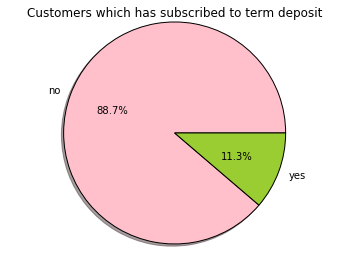

In [13]:
colors = ['pink', 'yellowgreen']

plot.pie(sizes, labels=labels, colors=colors, shadow=True, autopct='%1.1f%%')
plot.axis('equal')
plot.title('Customers which has subscribed to term deposit')
plot.show()

In [14]:
# tabella temp hive
filteredDF.registerTempTable("campaign")

queryResult = sqlContext.sql("SELECT age, job, marital FROM campaign WHERE has_subscribed = 'yes'")
queryResult.show()

+---+------------+--------+
|age|         job| marital|
+---+------------+--------+
| 41| blue-collar|divorced|
| 49|entrepreneur| married|
| 49|  technician| married|
| 41|  technician| married|
| 45| blue-collar| married|
| 42| blue-collar| married|
| 39|   housemaid| married|
| 28|     unknown|  single|
| 44|    services| married|
| 42|  technician| married|
| 42|  management| married|
| 39|    services| married|
| 42| blue-collar| married|
| 45|   housemaid| married|
| 31|      admin.|  single|
| 28|     student|  single|
| 41|entrepreneur| married|
| 37| blue-collar|  single|
| 44| blue-collar| married|
| 44|entrepreneur| married|
+---+------------+--------+
only showing top 20 rows



In [42]:
queryResult = sqlContext.sql("select count(1)/(select count(1) from campaign)*100 as conta, marital from campaign where has_subscribed = 'yes' group by marital")
queryResult.show()

+-------------------+--------+
|              conta| marital|
+-------------------+--------+
|0.02913469942701758| unknown|
| 1.1556764106050306|divorced|
|  6.147421579100709| married|
| 3.9331844226473733|  single|
+-------------------+--------+



### Split del Dataset

Il train di un modello e la validazione sugli stessi dati può essere un problema: un modello che riproduce solamente le etichette delle osservazioni che ha già visto avrebbe certamente uno score perfetto, ma fallirebbe nel compito di predirre qualcosa di utile su nuovi dati. Questa situazione si chiama _overfitting_.

Per evitare l' _overfitting_ è pratica comune (nel training supervisionato) effettuare lo split dei dati disponibili in _training_, _test_ e _validation_ dataset.

Creeremo dunque 3 set di dati:

 * training set: per il training dei nostri modelli di classificazione.
 * validation set : per valutare le performance del nostro modello addestrato e tuning sui parametri.
 * test set:  per testare il modello finale con dati mai visti negli step precedenti.

L'obbiettivo è creare un modello generalista che si adatta bene ai dati evitando l'_overfitting_.

In [43]:
# split training(60%), validation(20%) e test(20%) datasets
trainingDF, validationDF, testDF = filteredDF.randomSplit([0.6, 0.2, 0.2], seed=0)

In [44]:
trainingDF.cache()
validationDF.cache()
testDF.cache()

DataFrame[age: int, job: string, marital: string, education: string, default: string, housing: string, loan: string, contact: string, month: string, day_of_week: string, campaign: int, pdays: int, previous: int, outcome_of_prev: string, emp_variation_rate: double, consumer_price_idx: double, consumer_conf_idx: double, euribor3m: double, num_employees: double, has_subscribed: string, label: double]

In [45]:
print("Num of training observations : %s" % trainingDF.count())
print("Num of validation observations : %s" % validationDF.count())
print("Num of test observations : %s" % testDF.count())

Num of training observations : 24736
Num of validation observations : 8234
Num of test observations : 8218


### Trasformazione delle colonne categoriali

Per gli attributi categoriali, abbiamo bisogno di convertire quelle categorie testuali in attributi numerici prima di calcolare il train di un modello di classificazione.

Per esempio. l'attributo "marital", è un attributo categoriale con 4 possibili valori *'divorced','married','single','unknown'*,

Useremo la funzione _out-of-the-box_ di _featurization_ che ML mette a disposizione chiamata **One-hot enconding**, per trasformare questi attributi categoriali in un vettore di attributi binari. 
`VectorAssembler` verrà usato per assemblare i vettori degli attributi.

Se le variabili nel vettore degli attributi hanno una differenza in scala troppo grande, si potrebbe pensare a normalizzare con la _feature scaling_ . ML offre `standardScaler` per rispondere a questa esigenza. Vi sono anche tecniche di riduzione della dimensionalità quali PCA e SVD.

In [46]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

In [47]:
#convertiamo gli attributi categoriali in feature binarie
categoricalAttributes = ['job', 'marital', 'education', 'default', 
                         'housing', 'loan', 'contact', 
                         'month', 'day_of_week', 'outcome_of_prev']

In [48]:
#Costruiamo una lista di stage for the machine learning pipeline. 
pipelineStages = []
for columnName in categoricalAttributes:
    stringIndexer = StringIndexer(inputCol = columnName, outputCol = columnName + "Index")
    pipelineStages.append(stringIndexer)
    oneHotEncoder = OneHotEncoder(inputCol = columnName + "Index", outputCol=columnName + "Vec")
    pipelineStages.append(oneHotEncoder)

print("%s string indexer and one hot encoders transformers" %  len(pipelineStages))
assert len(pipelineStages) == len(categoricalAttributes)*2

20 string indexer and one hot encoders transformers


In [49]:
#Combiniamo le colonne delle features in una singola colonna del dataframe
numericColumns = ['age', 'campaign', 'pdays', 'previous','emp_variation_rate', 
                  'consumer_price_idx', 'consumer_conf_idx','euribor3m', 'num_employees']

categoricalCols = [ s + "Vec" for s in categoricalAttributes]
allFeatureCols =  numericColumns + categoricalCols

vectorAssembler = VectorAssembler(
    inputCols=allFeatureCols,
    outputCol="features")
pipelineStages.append(vectorAssembler)
print("%s feature columns: %s" % (len(allFeatureCols), allFeatureCols))

19 feature columns: ['age', 'campaign', 'pdays', 'previous', 'emp_variation_rate', 'consumer_price_idx', 'consumer_conf_idx', 'euribor3m', 'num_employees', 'jobVec', 'maritalVec', 'educationVec', 'defaultVec', 'housingVec', 'loanVec', 'contactVec', 'monthVec', 'day_of_weekVec', 'outcome_of_prevVec']


In [50]:
#Costruiamo la pipeline per l'estrazione delle feature
featurePipeline = Pipeline(stages = pipelineStages)
featureOnlyModel = featurePipeline.fit(trainingDF)

In [51]:
#Creiamo una lista di DataFrame con le features
trainingFeaturesDF = featureOnlyModel.transform(trainingDF)
validationFeaturesDF = featureOnlyModel.transform(validationDF)
testFeaturesDF = featureOnlyModel.transform(testDF)

trainingFeaturesDF.select("features", "label").show(2, False)

+-------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                   |label|
+-------------------------------------------------------------------------------------------------------------------------------------------+-----+
|(52,[0,1,2,3,4,5,6,7,8,19,21,25,30,32,34,36,39,51],[17.0,2.0,999.0,2.0,-2.9,92.201,-31.4,0.869,5076.2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|0.0  |
|(52,[0,1,2,3,4,5,6,7,8,19,21,25,30,32,34,36,39],[17.0,3.0,4.0,2.0,-2.9,92.201,-31.4,0.869,5076.2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])         |0.0  |
+-------------------------------------------------------------------------------------------------------------------------------------------+-----+
only showing top 2 rows



### Classificazione non supervisionata - Clustering con Gaussian Mixture

ML offre alcuni metodi di clusterizzazione non supervisionata, che possono tornare utili quando si ha a che fare con dati non etichettati, e quindi è impossibile applicare algoritmi di learning supervisionati.

Calcoliamo il train di un modello con Gaussian mixture e vediamo come si comporta sui nostri dati.

In [93]:
from pyspark.mllib.clustering import KMeans, KMeansModel, GaussianMixture
from pyspark.mllib.linalg import Vector as MLLibVector, Vectors as MLLibVectors
from numpy import array
from math import sqrt

In [91]:
#Estraiamo le "features" dal training set in formato vettore 
def extractVectorFeatures(featuresDF):
    return featuresDF.select("features").rdd.map(lambda row: MLLibVectors.sparse(row[0].size, row[0].indices, row[0].values))

#Funzione per calcolare l'accuratezza
def calculateAccuracy(labelsAndPredictionsRdd):
    """""
        Calculate accuracy for a given label and prediction RDD
        input:  
            labelsAndPredictionsRdd : RDD consisting of tuples (label, prediction)
        
        return: float accuracy in percentage
    """""
    return (labelsAndPredictionsRdd.filter(lambda l_p: l_p[0] == l_p[1]).count() 
            / float(labelsAndPredictionsRdd.count())* 100)

In [92]:
#Costruzione del modello
trainingRdd = extractVectorFeatures(trainingFeaturesDF)

numOfClusters = 2
gmm = GaussianMixture.train(trainingRdd, numOfClusters)

def getGmmPredictedAccuracy(featuresDF, featuresRdd, model):
    #Predizione sul featuresRdd
    predictionList = model.predict(featuresRdd).collect()
    actualAndPred = (featuresDF.select("label").rdd
            .map(lambda row: row.label)
            .zipWithIndex()
            .map(lambda l_i: (l_i[0], predictionList[l_i[1]])) )
    # mappare le features del train data frame con le etichette predette e indicizzate
    return calculateAccuracy(actualAndPred)

# Prediciamo il training set con il GMM cluster model
trainGmmAccuracy = getGmmPredictedAccuracy(trainingFeaturesDF, trainingRdd, gmm)

#ripetiamo col test set
testRdd = extractVectorFeatures(testFeaturesDF)
testGmmAccuracy = getGmmPredictedAccuracy(testFeaturesDF, testRdd, gmm)

#ripetiamo con il validation set
validationRdd = extractVectorFeatures(validationFeaturesDF)
validationGmmAccuracy = getGmmPredictedAccuracy(validationFeaturesDF, validationRdd, gmm)

print("==========================================")
print("GMM accuracy against unfiltered training set(%) = " + str(trainGmmAccuracy))
print("GMM accuracy against test set(%) = " + str(testGmmAccuracy))
print("GMM accuracy against validation set(%) = " + str(validationGmmAccuracy))
print("==========================================")

GMM accuracy against unfiltered training set(%) = 77.83392626131953
GMM accuracy against test set(%) = 77.90216597712339
GMM accuracy against validation set(%) = 77.84794753461259


### Learning supervisionato

Negli step precedenti, abbiamo messo insieme una lista di encoders per codificare le nostre variabili categoriali. Adesso procederemo ad usare le API con cui costruiremo la nostra pipeline. Il vantaggio della pipeline API consiste nel legare i _trasformatori_ (codificatori di features, selezionatori etc) e _stimatori_ (il modello) insieme e aumentando la riusabilità del codice.

[Documentazione](https://spark.apache.org/docs/latest/api/python/_modules/pyspark/ml/classification.html) sulle Pyspark API per la classificazione.

Negli step successivi inoltre creeremo una regressione logistica dove il modello calcolerà le predizioni applicando la funzione logistica. Il parametro di tuning è  `regParam` e viene utilizzato per prevenire l'_overfitting_ penalizzando i modelli con valori estremi nella parametrizzazione.

In [57]:
from pyspark.ml.classification import LogisticRegression

# Configura una pipeline di machine learning, che consiste 
# in un estimatore(classificazione) (Logistic regression)
lr = LogisticRegression(maxIter=10, regParam=0.01)
lrPipeline = Pipeline(stages=[lr])

# Fit the pipeline to create a model from the training data
lrPipelineModel = lrPipeline.fit(trainingFeaturesDF)

In [58]:
#Funzione per calcolare l'accuratezza su DF
def calculateAccuracy(labelsAndPredictionsDF):
    """""
        Calculate accuracy for a given label and prediction DF
        input:  
            labelsAndPredictionsDF : DF consisting columns (label, prediction)
        
        return: float accuracy in percentage
    """""
    return (labelsAndPredictionsDF.where(labelsAndPredictionsDF.label == labelsAndPredictionsDF.prediction).count() 
            / float(labelsAndPredictionsDF.count())* 100)


def getAccuracyForPipelineModel(featuresDF, model):
    #Calcola la predizione utilizzando la featuresdF el pipelineModel
    #Calcola l'accuratezza della predizione rispetto ai label
    results = model.transform(featuresDF)
    labelsAndPreds = results.select("label", "prediction")

    return (calculateAccuracy(labelsAndPreds), results)

In [59]:
# calcola il modello su training data
lrTrainAccuracy, lrTrainResultDF = getAccuracyForPipelineModel(trainingFeaturesDF, lrPipelineModel)

# ripete sul test data
lrTestAccuracy, lrTestResultDF = getAccuracyForPipelineModel(testFeaturesDF, lrPipelineModel)

# ripete sul validation data
lrValidationAccuracy, lrValidationResultDF = getAccuracyForPipelineModel(validationFeaturesDF, lrPipelineModel)

print("==========================================")
print("LogisticRegression Model training accuracy (%) = " + str(lrTrainAccuracy))
print("LogisticRegression Model test accuracy (%) = " + str(lrTestAccuracy))
print("LogisticRegression Model validation accuracy (%) = " + str(lrValidationAccuracy))
print("==========================================")

LogisticRegression Model training accuracy (%) = 89.39602199223803
LogisticRegression Model test accuracy (%) = 89.8515453881723
LogisticRegression Model validation accuracy (%) = 90.44206946805927


Si può anche creare una pipeline combinando più pipelines ( ad esempio la feature extraction pipeline, e la classification pipeline)

In [60]:
combinedPipeline = Pipeline(stages= [featurePipeline, lrPipeline])

In [61]:
#Calcoliamo la predizione del modello a partire dai test data
selected = lrTestResultDF.select("has_subscribed", "label", "prediction")

#Mostriamo il numero dei risultati predetti
predictedLabel = selected.groupBy("prediction").count()
predictedLabel.show()

selected.show(20)

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 7926|
|       1.0|  292|
+----------+-----+

+--------------+-----+----------+
|has_subscribed|label|prediction|
+--------------+-----+----------+
|           yes|  1.0|       0.0|
|            no|  0.0|       1.0|
|            no|  0.0|       0.0|
|            no|  0.0|       1.0|
|           yes|  1.0|       0.0|
|            no|  0.0|       1.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|           yes|  1.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       1.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
|            no|  0.0|       0.0|
+--------------+-----+----------+
only showing top 20 rows



### Tuning dei parametri con la Grid search

Uno dei task principali in machine learning è usare i dati per trovare i parametri ottimali del nostro modello di classificazione.

Nella sezione successiva, proveremo a calcolare il train del modello di Logistic Regression con differenti valori per l'ottimizzazione dei parametri `regParam` e il numero massimo di iterazioni. L'accuratezza del modello è validata con il _validation_ dataset che abbiamo creato prima.

In [80]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import numpy as np
from math import log

maxIterRange = [5, 10, 30, 50, 100]
regParamRange = [1e-10, 1e-5, 1e-1]

In [81]:
#baseline
bestIter = 10
bestRegParam = 0.01
bestModel = lr
bestAccuracy = lrValidationAccuracy

In [82]:
#per il plot
iterations = []
regParams = []
accuracies = []

for maxIter in maxIterRange:
    for rp in regParamRange:
        currentLr = LogisticRegression(maxIter=maxIter, regParam=rp)
        pipeline = Pipeline(stages=[currentLr])
        model = pipeline.fit(trainingFeaturesDF)
        
        #validation data set per accuratezza
        accuracy, resultDf = getAccuracyForPipelineModel(validationFeaturesDF, model)
        print("maxIter: %s, regParam: %s, accuracy: %s " % (maxIter, rp, accuracy))
        accuracies.append(accuracy)
        regParams.append(log(rp))
        iterations.append(maxIter)

        if accuracy > bestAccuracy:
            bestIter = maxIter
            bestRegParam = rp
            bestModel = model
            bestAccuracy = accuracy


print("Best parameters: maxIter %s, regParam %s, accuracy : %s" % (bestIter, bestRegParam, bestAccuracy))

maxIter: 5, regParam: 1e-10, accuracy: 89.42190915715327 
maxIter: 5, regParam: 1e-05, accuracy: 89.42190915715327 
maxIter: 5, regParam: 0.1, accuracy: 89.42190915715327 
maxIter: 10, regParam: 1e-10, accuracy: 90.4663589992713 
maxIter: 10, regParam: 1e-05, accuracy: 90.4663589992713 
maxIter: 10, regParam: 0.1, accuracy: 90.27204274957494 
maxIter: 30, regParam: 1e-10, accuracy: 90.36920087442313 
maxIter: 30, regParam: 1e-05, accuracy: 90.36920087442313 
maxIter: 30, regParam: 0.1, accuracy: 90.41777993684723 
maxIter: 50, regParam: 1e-10, accuracy: 90.62424095214962 
maxIter: 50, regParam: 1e-05, accuracy: 90.63638571775566 
maxIter: 50, regParam: 0.1, accuracy: 90.42992470245325 
maxIter: 100, regParam: 1e-10, accuracy: 90.58780665533155 
maxIter: 100, regParam: 1e-05, accuracy: 90.55137235851348 
maxIter: 100, regParam: 0.1, accuracy: 90.41777993684723 
Best parameters: maxIter 50, regParam 1e-05, accuracy : 90.63638571775566


In [83]:
# ripeti sul test data
gridTestAccuracy, gridTestResultDf = getAccuracyForPipelineModel(testFeaturesDF, bestModel)

print("==========================================")
print("Grid search Model test accuracy (%) = " + str(gridTestAccuracy))
print("==========================================")

Grid search Model test accuracy (%) = 90.04623996106108


/home/merlinuser/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


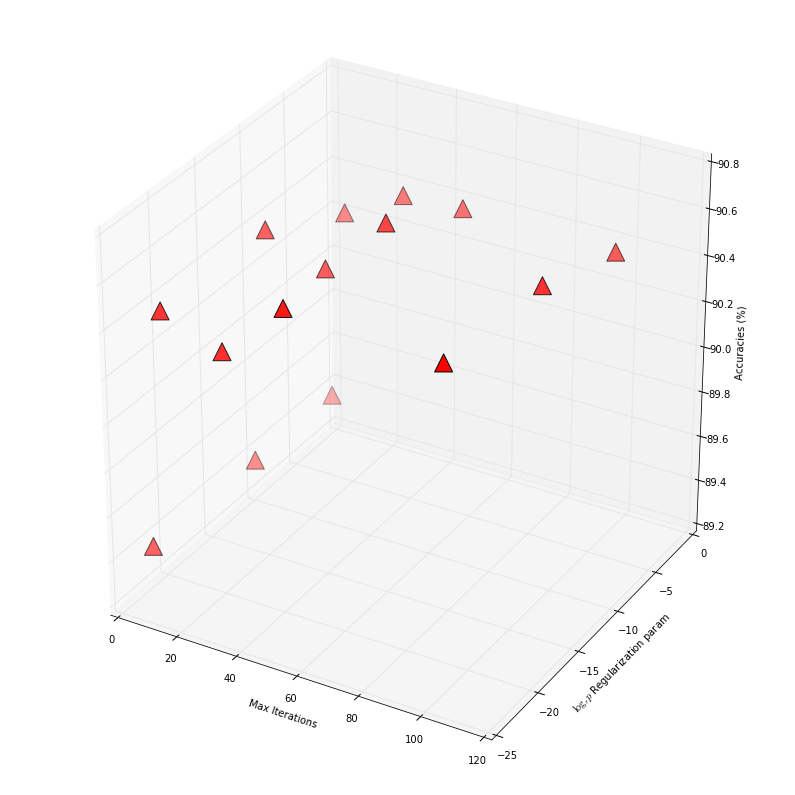

In [84]:
# visualizziamo il risultato
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plot.figure(figsize=(14, 14), facecolor='white', edgecolor='white')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(iterations, regParams, accuracies, 
           s=18**2, c='r', marker='^')

ax.legend()
ax.set_xlabel('Max Iterations')
ax.set_ylabel(r'$\log_rp$ Regularization param')
ax.set_zlabel('Accuracies (%)')


plot.show()

### Cross Validation

Spark supporta anche il tuning di modelli tramite la [_cross validation_](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29) .

In una tipica (k-fold) cross validation, il training dataset viene suddiviso in _k_ sottoinsiemi.

La seguente procedura è ripetuta per ognuno dei _k_ sottoinsiemi:
 * Un modello è allenato utilizzando _k-1_ dei sottoinsiemi come training dataset.
 * Il modello risultante è validato sulla parte rimanente dei dati, per calcolarne l'accuratezza.
 * Viene calcolata la media dei valori delle misure di performance riportate dal k-fold cross-validation.
 
In questo esercizio utilizzeremo la classe `CrossValidator` proveniente dal pacchetto `pyspark.ml.tuning`.
([Documentazione](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator))

La cross validation è computazionalmente costosa, potrebbe tardare qualche minuto.

In [86]:
# Usiamo un ParamGridBuilder per costruire una griglia di parametri
# su cui ricercare.
grid = (ParamGridBuilder()
        .addGrid(lr.maxIter, maxIterRange) 
        .addGrid(lr.regParam,regParamRange )
        .build())

In [87]:
evaluator = BinaryClassificationEvaluator()

In [88]:
# Adesso trattiamo la Pipeline come uno Stimatore
# mettendolo all'interno di un' istanza CrossValidator.
# Un CrossValidator richiede uno Stimatore, 
# un insieme di ParamMaps e un Evaluator
crossValidator = CrossValidator(estimator=lrPipeline, 
                                estimatorParamMaps=grid, 
                                numFolds=5,
                                evaluator=evaluator)

In [89]:
# Calcoliamo la cross-validation, e scegliamo il miglior modello
bestCvModel = crossValidator.fit(trainingFeaturesDF)

# Verifichiamo il risultato sul training Dataset
cvTrainAccuracy, cvTrainResultDF = getAccuracyForPipelineModel(trainingFeaturesDF, bestCvModel)

# Ripetiamo sui test data
cvTestAccuracy, cvTestResultDF = getAccuracyForPipelineModel(testFeaturesDF, bestCvModel)

print("==========================================")
print("CV Model training accuracy (%) = " + str(cvTrainAccuracy))
print("CV Model test accuracy (%) = " + str(cvTestAccuracy))
print("==========================================")

CV Model training accuracy (%) = 89.82050452781371
CV Model test accuracy (%) = 90.05840837186663


In [94]:
sc.stop()